## POOL DOGE_WETH

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [64]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [66]:
EXPERIMENT_ID = 90

X_NAME = 'DOGE'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [67]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [68]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [69]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [70]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [71]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330


In [72]:
swaps0_df.status.value_counts()

SUCCESS                12174
NOT_ENOUGH_RESERVES        1
Name: status, dtype: int64

In [73]:
swaps1_df.status.value_counts()

SUCCESS                             12063
BLOCKED_BY_VOLATILITY_MITIGATION      111
NOT_ENOUGH_RESERVES                     1
Name: status, dtype: int64

In [74]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.009117043121149897


In [75]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                12171
CANT_CONSULT_ORACLE        3
NOT_REACHED                1
Name: mitigator_check_status, dtype: int64

In [76]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.0002464065708418891


In [77]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64


**0** have been **blocked by the volatility mitigation mechanism**. In only 0.4% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (77% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

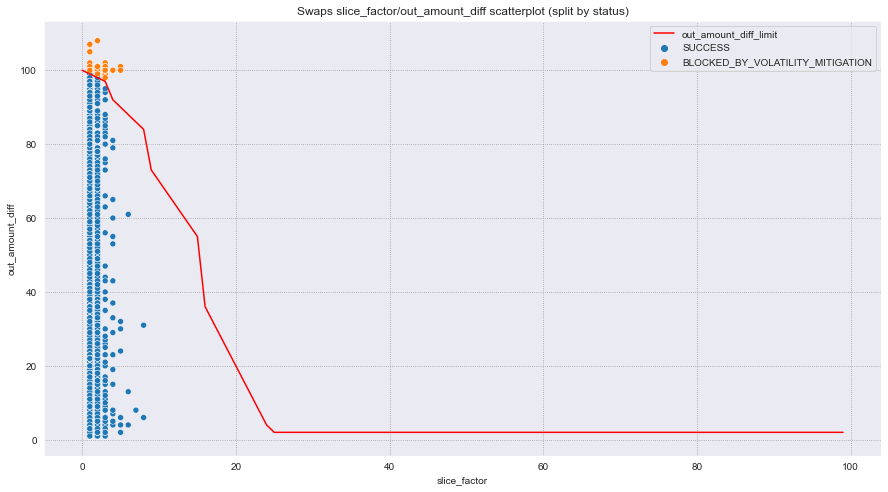

In [78]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [79]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12170,12212,DOGE,WETH,3100.579942,0.0,0.167324,0.000669,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1779349.0,2021-11-23 19:12:04,2021-11-23 19:12:01,0x7a086f670f8a3ce344a58cc76a01e204816de742e422...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,12212,1.376499e+07,750.502507,1.033066e+10,2077,558373237420,False,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,0.000054,-0.000449
12171,12213,DOGE,WETH,38241.829903,0.0,2.057607,0.008230,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782494.0,2021-11-24 08:18:19,2021-11-24 08:18:12,0xdb47f7f45ec9f7f5a5650ead3a206b2c3d61c0de4bf6...,0xb2bbfd73971279a457514325f209eb63a0341ef2,0xb2bbfd73971279a457514325f209eb63a0341ef2,12213,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,0.000054,-0.005515
12172,12214,DOGE,WETH,100000.000000,0.0,5.327351,0.021309,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782894.0,2021-11-24 09:58:19,2021-11-24 09:58:15,0xc3a2b979eae3d49d64d85863c9578c987f9732089aa1...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,12214,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,1.390633e+07,742.920016,1.033129e+10,2080,559521242596,False,0.000053,-0.014288
12173,12215,DOGE,WETH,40517.171810,0.0,2.136746,0.008547,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1786322.0,2021-11-25 00:15:19,2021-11-25 00:15:15,0x5bd

Text(0, 0.5, 'Count')

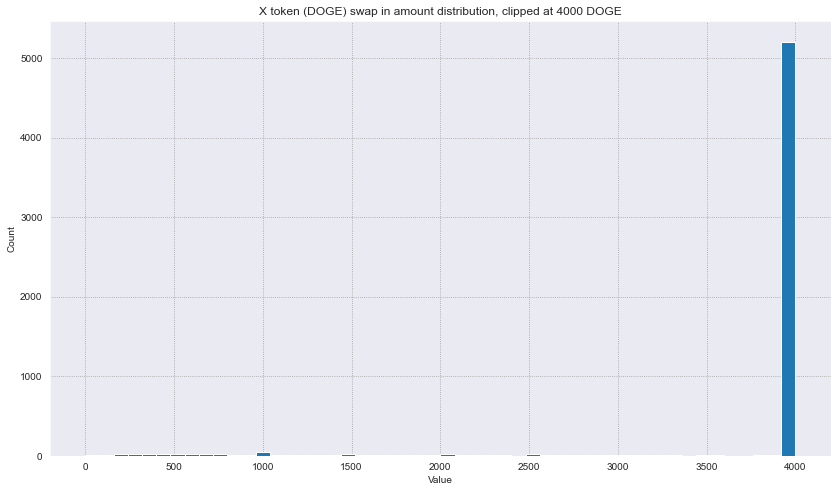

In [80]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

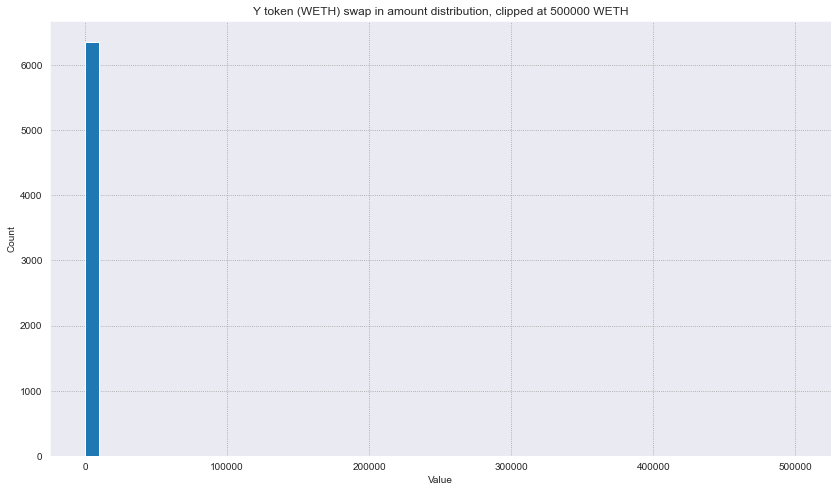

In [81]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

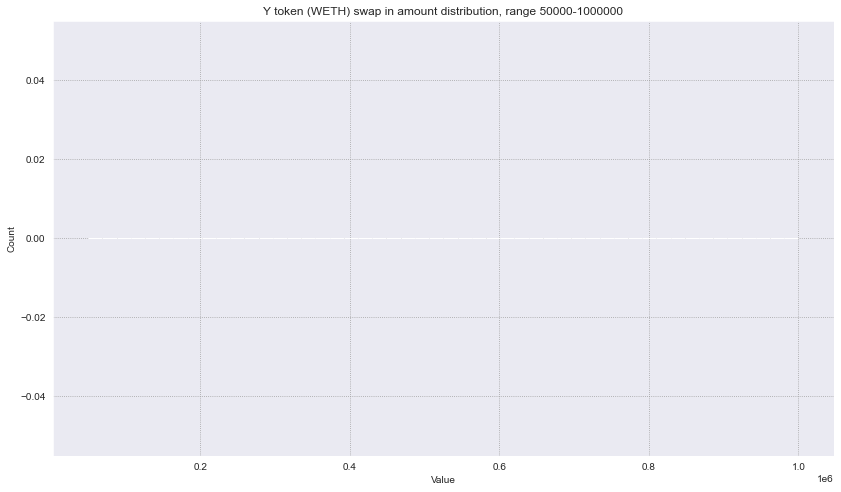

In [82]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

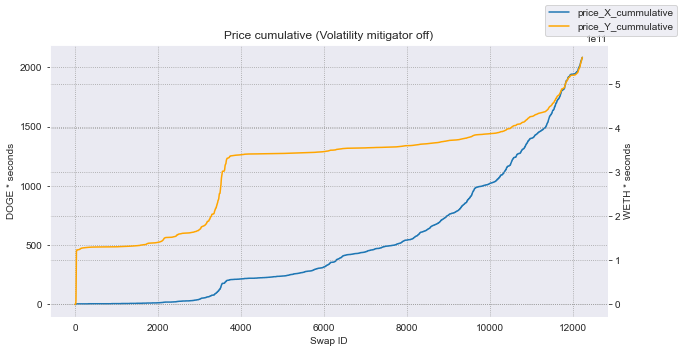

In [83]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

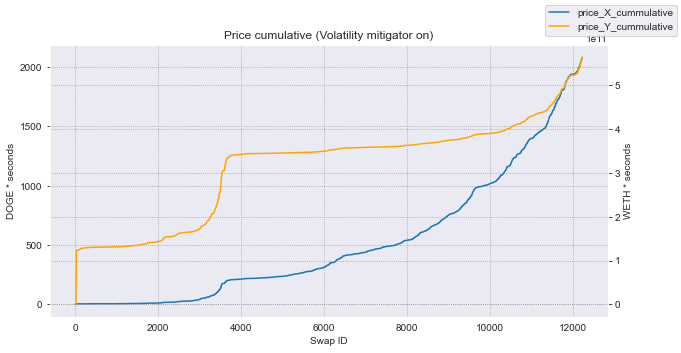

In [84]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

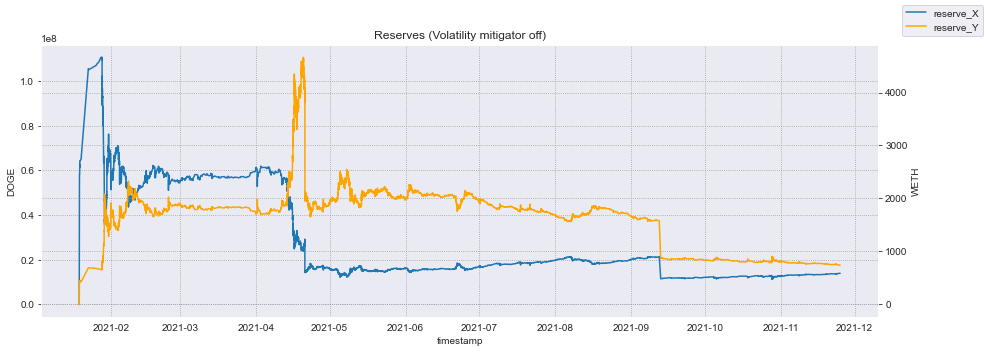

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

(18655.125, 18658.0)

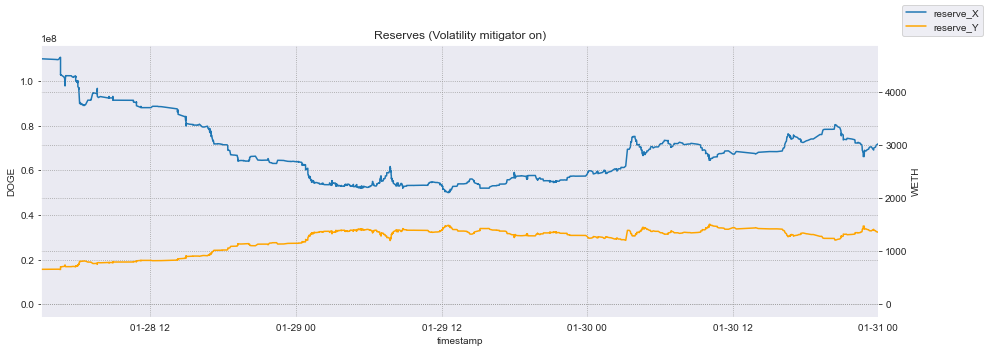

In [95]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))


**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

(0.0, 7e-05)

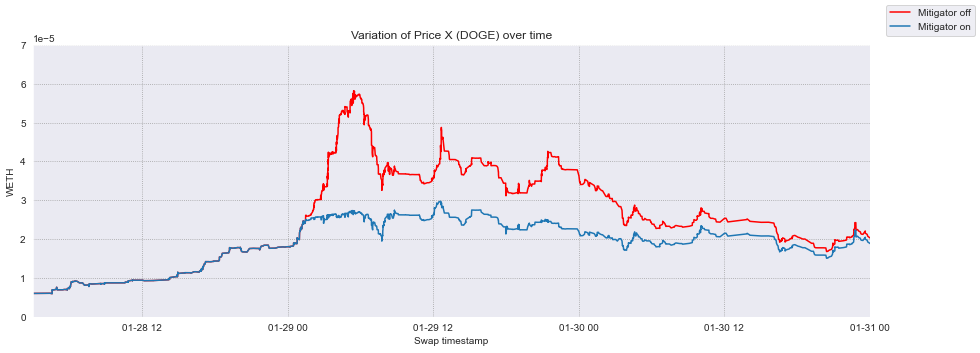

In [93]:
import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))
ax.set_ylim(0,0.00007)

In [88]:
datetime.datetime(2021, 1, 18, 12, 12, 12)

datetime.datetime(2021, 1, 18, 12, 12, 12)

In [89]:
#datetime.datetime(2021, 1, 18, 12, 12, 12)

In [90]:
swaps1_df[swaps1_df.status != 'SUCCESS']

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000e+00,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,True,0.000000e+00,0.000000,0.000000e+00,0,0,True,NaN,NaN
434,443,WETH,DOGE,30.000000,0.0,1.161152e+06,NaN,CHECKED,3.530303e+06,100.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,58619.0,2021-01-29 01:29:34,2021-01-29 01:29:33,0xa5a6f396fd743d801e6353580a07786f8b3833382583...,0x00000000006e3895f955d0a15f79b7477d7b9b2f,0x23bb4e19767c51afd9bebdd5cb23ced735b97618,443,5.429472e+07,1359.052869,7.378939e+10,6,130192171322,True,5.429472e+07,1359.052869,7.378939e+10,6,130192770578,True,0.000025,0.0
461,470,WETH,DOGE,10.000000,0.0,3.861385e+05,NaN,CHECKED,1.163608e+06,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58754.0,2021-01-29 02:03:19,2021-01-29 02:03:06,0xf90b52158c8d0fdd61895d8b4a536876844330084109...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x950882ce40c6b5ba235d42dfee7eedbf5cd7fb61,470,5.384408e+07,1370.579692,7.379760e+10,6,130261265248,True,5.384408e+07,1370.579692,7.379760e+10,6,130273640220,True,0.000025,0.0
462,471,WETH,DOGE,10.000000,0.0,3.861385e+05,NaN,CHECKED,1.163028e+06,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58760.0,2021-01-29 02:04:49,2021-01-29 02:04:36,0x17546d46dfff0270997b5ac08d3152f6f7a213a44dfc...,0x00000000006e3895f955d0a15f79b7477d7b9b2f,0x23bb4e19767c51afd9bebdd5cb23ced735b97618,471,5.384408e+07,1370.579692,7.379760e+10,6,130273640220,True,5.384408e+07,1370.579692,7.379760e+10,6,130277175926,True,0.000025,0.0
464,473,WETH,DOGE,11.969637,0.0,4.613974e+05,NaN,CHECKED,1.390603e+06,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58773.0,2021-01-29 02:08:04,2021-01-29 02:08:00,0xe56fb22d1c6c5c28ba932a593537e7d3475a489614f1...,0xe34820500dcd2a2c3c4ce2c1cac561e30ede0dc7,0xe34820500dcd2a2c3c4ce2c1cac561e30ede0dc7,473,5.383564e+07,1370.795753,7.379767e+10,6,130282479485,True,5.383564e+07,1370.795753,7.379767e+10,6,130284835882,True,0.000025,0.0
467,476,WETH,DOGE,22.976260,0.0,8.785896e+05,NaN,CHECKED,2.667560e+06,100.0,2.0,2.0,BLOCKED_BY_VOLATILITY_MITIGATION,58781.0,2021-01-29 02:10:04,2021-01-29 02:09:50,0x9e3056d10a4bb0e30c0b5ff1c7f296daa334d1f8a66b...,0x682abadc25ebe6c95a6054cc56ae1ec8c46a8c37,0x682abadc25ebe6c95a6054cc56ae1ec8c46a8c37,476,5.383107e+07,1370.928436,7.379855e+10,6,130288370477,True,5.383107e+07,1370.928436,7.379855e+10,6,130289548461,True,0.000025,0.0
470,479,WETH,DOGE,28.977750,0.0,1.120761e+06,NaN,CHECKED,3.363233e+06,100.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,58785.0,2021-01-29 02:11:04,2021-01-29 02:10:53,0x0ab86455ebd7bfc411f0bcb904c816b8d23cccd22e02...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,479,5.425919e+07,1360.176992,7.380210e+10,6,130291343779,True,5.425919e+07,1360.176992,7.380210e+10,6,130291942148,True,0.000025,0.0
479,488,WETH,DOGE,2.917462,0.0,1.124927e+05,NaN,CHECKED,3.378583e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58812.0,2021-01-29 02:17:49,2021-01-29 02:17:38,0x7eb133e8313d67833a5286ca0de37035e217e9a810cd...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbd32ea03b2e69f965d923eb9c6154c4c2fdb41bd,488,5.367180e+07,1375.153185,7.380695e+10,6,130307970095,True,5.367180e+07,1375.153185,7.380695e+10,6,130307970095,True,0.000026,0.0
485,494,WETH,DOGE,1.000000,0.0,3.846445e+04,NaN,CHECKED,1.153962e+05,100.0,1.0,1.0,BLOCKED_BY_

In [40]:
swaps1_df.iloc[500:600]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
500,509,DOGE,WETH,391157.738035,0.0,1.179069e+01,0.047163,CHECKED,5.212876e+00,77.0,1.0,1.0,SUCCESS,58926.0,2021-01-29 02:46:19,2021-01-29 02:46:09,0x8ed8245f8a26da5834386dabdfc26c726b347df444f8...,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,509,4.905808e+07,1505.487795,7.385634e+10,6,130357408869,True,4.944923e+07,1493.649944,7.385985e+10,6,130357408869,True,0.000030,-0.015711
501,510,WETH,DOGE,32.136883,0.0,1.031326e+06,0.128548,CHECKED,2.811915e+06,92.0,3.0,3.0,SUCCESS,58926.0,2021-01-29 02:46:19,2021-01-29 02:46:09,0xe26056d0e2899382f8544bf65b0a9598438c155cac99...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,510,4.944923e+07,1493.649944,7.385985e+10,6,130357408869,True,4.841791e+07,1525.658280,7.386918e+10,6,130357408869,True,0.000032,0.043187
502,511,WETH,DOGE,2.000000,0.0,6.275534e+04,0.008000,CHECKED,1.748518e+05,94.0,1.0,1.0,SUCCESS,58933.0,2021-01-29 02:48:04,2021-01-29 02:47:52,0x1110e6b188c4f1968ca693d68c7190cd8f562627759e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6747a058b5f1822694d4da63ca2e59c61041f6ee,511,4.841791e+07,1525.658280,7.386918e+10,6,130357408869,True,4.835515e+07,1527.650280,7.386976e+10,6,130360741122,True,0.000032,0.002605
503,512,WETH,DOGE,0.370984,0.0,1.162264e+04,0.001484,CHECKED,3.243360e+04,94.0,1.0,1.0,SUCCESS,58933.0,2021-01-29 02:48:04,2021-01-29 02:48:02,0x2c43da5e03af47b8eca3d36a2e1c49b3c334618f7fef...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5de953d5b76f349d19d8a956793ff4cabab86d07,512,4.835515e+07,1527.650280,7.386976e+10,6,130360741122,True,4.834353e+07,1528.019780,7.386987e+10,6,130360741122,True,0.000032,0.000482
504,513,WETH,DOGE,13.233023,0.0,4.109567e+05,0.052932,CHECKED,1.156636e+06,95.0,1.0,1.0,SUCCESS,58935.0,2021-01-29 02:48:34,2021-01-29 02:48:28,0x90ed9a8e312e0fe92240a980c44def9538e988b14057...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,513,4.834353e+07,1528.019780,7.386987e+10,6,130360741122,True,4.793257e+07,1541.199871,7.387368e+10,6,130361690263,True,0.000032,0.017273
505,514,WETH,DOGE,4.000000,0.0,1.228436e+05,0.016000,CHECKED,3.493717e+05,95.0,1.0,1.0,SUCCESS,58941.0,2021-01-29 02:50:04,2021-01-29 02:50:00,0x9d16c6352bbda1a805bb64719935e0acd62016a5f39f...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x118a87c2f8e06da3025f33a627523596fd4fe8c5,514,4.793257e+07,1541.199871,7.387368e+10,6,130361690263,True,4.780973e+07,1545.183871,7.387482e+10,6,130364489337,True,0.000032,0.005161
506,515,WETH,DOGE,0.350000,0.0,1.071870e+04,0.001400,CHECKED,3.055546e+04,96.0,1.0,1.0,SUCCESS,58945.0,2021-01-29 02:51:04,2021-01-29 02:50:59,0x0069cb30a7a291cb43e8369aed5cfaf56d9f96237cfb...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd940aeb52a498b0df3e2fd456b765b1350e1f03f,515,4.780973e+07,1545.183871,7.387482e+10,6,130364489337,True,4.779901e+07,1545.532471,7.387492e+10,6,130366345804,True,0.000032,0.000450
507,516,WETH,DOGE,4.590070,0.0,1.401265e+05,0.018360,CHECKED,4.007191e+05,96.0,1.0,1.0,SUCCESS,58945.0,2021-01-29 02:51:04,2021-01-29 02:50:59,0x47650a668732052df9fe0f421b1363ef3de6e7722f2e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf1d2eaaa8d87562b24445efbbecc83793e45c9c1,516,4.779901e+07,1545.532471,7.387492e+10,6,130366345804,True,4.765888e+07,1550.104181,7.387624e+10,6,130366345804,True,0.000033,0.005907
508,517,WETH,DOGE,0.500000,0.0,1.521421e+04,0.002000,CHECKED,4.361419e+04,96.0,1.0,1.0,SUCCESS,58952.0,2021-01-29 02:52:49,2021-01-29 02:52:45,0x3914d0f005da

**The variation of price is the same as in the initial version**

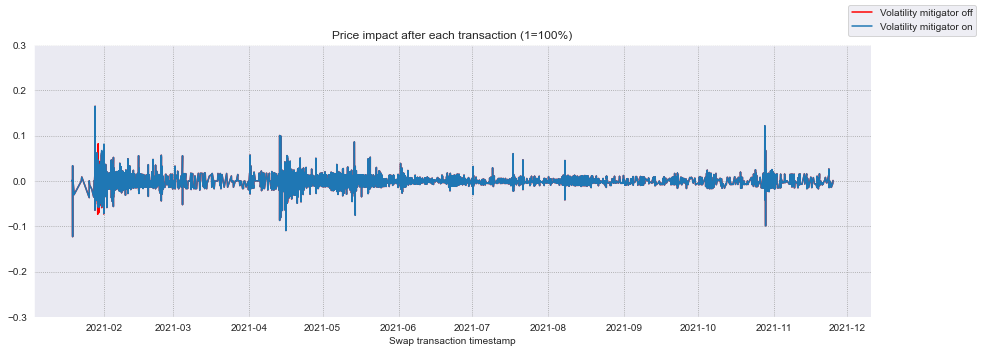

In [97]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In [26]:
swaps1_df[swaps1_df.price_diff > 0.1]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
35,42,WETH,DOGE,50.000000,0.0,7.728341e+06,0.20000,CHECKED,8.208890e+06,6.0,8.0,16.0,SUCCESS,53604.0,2021-01-28 04:35:49,2021-01-28 04:35:38,0xda0daf51c9ff4dbd17969112f13f886fb03e80449af5...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xe77199646fe90725cbf01444813cdc4461e7102c,42,1.105099e+08,658.315601,7.275040e+10,5,123465676300,True,1.027816e+08,708.115601,7.278123e+10,5,123465676300,True,0.000007,0.156528
76,83,WETH,DOGE,60.000000,0.0,7.099884e+06,0.24000,CHECKED,9.783966e+06,31.0,8.0,16.0,SUCCESS,53981.0,2021-01-28 06:10:04,2021-01-28 06:10:01,0xf92250be0686203e83fae3f990fd09f2a2d24fda9348...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xe77199646fe90725cbf01444813cdc4461e7102c,83,9.694875e+07,751.705645,7.287692e+10,5,124231778976,True,8.984887e+07,811.465645,7.290927e+10,5,124264666758,True,0.000009,0.164802
3724,3748,WETH,DOGE,92.317589,0.0,2.612461e+06,0.36927,CHECKED,2.755735e+06,5.0,5.0,10.0,SUCCESS,487365.0,2021-04-13 11:56:04,2021-04-13 11:55:50,0x7c0446eefa9b1812cd5ebab6e6703f96b69db8757176...,0x59903993ae67bf48f10832e9be28935fee04d6f6,0x59903993ae67bf48f10832e9be28935fee04d6f6,3748,5.616594e+07,1873.516869,1.052278e+11,209,337411472608,True,5.355348e+07,1965.465188,1.052575e+11,209,337411472608,True,0.000037,0.100254
11925,11967,WETH,DOGE,50.000000,0.0,6.774639e+05,0.20000,CHECKED,8.032811e+05,16.0,6.0,12.0,SUCCESS,1626592.0,2021-10-28 06:42:49,2021-10-28 06:42:43,0x8479c41ee28e2c3718bce6873ab931a12246ef3d459e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5ebca96200943db8cc27866a484abbd57a06b0ba,11967,1.215080e+07,838.317676,1.018623e+10,1940,520415912175,True,1.147333e+07,888.117676,1.018967e+10,1940,520415912175,True,0.000077,0.121959


In [27]:
swaps1_df.iloc[615:623]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
615,624,WETH,DOGE,0.440447,0.0,12824.239390,0.001762,CHECKED,37655.399369,98.0,1.0,1.0,SUCCESS,59121.0,2021-01-29 03:35:04,2021-01-29 03:35:04,0xbdcb857bdb0177aad33a32caa7b5219ca54f442a9504...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0398219ff15f6fb810cd10c214d39331e2c17df6,624,4.665970e+07,1586.059447,7.400505e+10,6,130445059621,True,4.664687e+07,1586.498132,7.400517e+10,6,130445059621,True,0.000034,0.000552
616,625,WETH,DOGE,0.100000,0.0,2910.657102,0.000400,CHECKED,8549.365625,98.0,1.0,1.0,SUCCESS,59121.0,2021-01-29 03:35:04,2021-01-29 03:35:04,0xc8cc0bea5ba85ec60ed305a59ceba1fe9ca6054c8c30...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6125738b8765809ff865565b1354822fc5e0d8b6,625,4.664687e+07,1586.498132,7.400517e+10,6,130445059621,True,4.664396e+07,1586.597732,7.400520e+10,6,130445059621,True,0.000034,0.000125
617,626,WETH,DOGE,0.200000,0.0,5820.222430,0.000800,CHECKED,17096.727144,98.0,1.0,1.0,SUCCESS,59122.0,2021-01-29 03:35:19,2021-01-29 03:35:06,0x94365242d69d01a091c1fcfdb77014a45db92f5424c1...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x718def6383435d6581159b67c87ebb97b4a8f8a2,626,4.664396e+07,1586.597732,7.400520e+10,6,130445059621,True,4.663814e+07,1586.796932,7.400526e+10,6,130445500602,True,0.000034,0.000250
618,627,WETH,DOGE,0.622234,0.0,18098.394279,0.002489,CHECKED,53184.567437,98.0,1.0,1.0,SUCCESS,59123.0,2021-01-29 03:35:34,2021-01-29 03:35:24,0x7deb8da9a47cf27299eeecc56c1655932c87358f0a31...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5b3b1de2e1cf13580c2cc0ec265091adc36bcbd0,627,4.663814e+07,1586.796932,7.400526e+10,6,130445500602,True,4.662004e+07,1587.416677,7.400543e+10,6,130445941472,True,0.000034,0.000779
619,628,WETH,DOGE,0.469280,0.0,13640.228061,0.001877,CHECKED,40106.335388,98.0,1.0,1.0,SUCCESS,59124.0,2021-01-29 03:35:49,2021-01-29 03:35:47,0x4374e773cb760f8848477d46837aade1cceca124b3d1...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x650786a0b235e9588e628f3cea57bae429c68ff9,628,4.662004e+07,1587.416677,7.400543e+10,6,130445941472,True,4.660640e+07,1587.884080,7.400556e+10,6,130446382000,True,0.000034,0.000587
620,629,WETH,DOGE,0.102804,0.0,2987.072598,0.000411,CHECKED,8778.831029,98.0,1.0,1.0,SUCCESS,59131.0,2021-01-29 03:37:34,2021-01-29 03:37:20,0xdc1d555ec5caa2bbac7d919abcf46d06bd49cbd9ff00...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6e835a33b86136f42d568757538d9d36197b0bab,629,4.660640e+07,1587.884080,7.400556e+10,6,130446382000,True,4.660341e+07,1587.986473,7.400559e+10,6,130449463882,True,0.000034,0.000129
621,630,WETH,DOGE,5.000000,0.0,144818.644338,0.020000,CHECKED,426668.177796,98.0,1.0,1.0,SUCCESS,59137.0,2021-01-29 03:39:04,2021-01-29 03:38:52,0x4ab9edb4ebf9f9746523fde2c508df95bd28b4984f10...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x1a9a6baf898fb0c6265f1a3d33660db0a8bc9909,630,4.660341e+07,1587.986473,7.400559e+10,6,130449463882,True,4.645860e+07,1592.966473,7.400699e+10,6,130452105156,True,0.000034,0.006263
622,631,WETH,DOGE,0.010000,0.0,288.730018,0.000040,CHECKED,852.936364,98.0,1.0,1.0,SUCCESS,59141.0,2021-01-29 03:40:04,2021-01-29 03:39:53,0x368d97e93fe4d1dae74e8679fdf5e774cc10c667ea14...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x654003b19f48bca3cf83b570982017aa364be312,631,4.645860e+07,1592.966473,7.400699e+10,6,130452105156,True,4.645831e+07,1592.976433,7.400699e+10,6,130453855046,True,0.000034,0.000012


**The price impact after each transaction doesn't exceed 0.25 and is the same as initially before the modification in the DSW oracle**